# max entropy prior using normalizing-flow
In `nb/max_entropy_prior_correction.ipynb`, we were able to use the maximum entropy priors to impose uniform priors on $P({\rm SSFR}_{1Gyr})$ and $P({\rm SSFR}_{100Myr})$ individually. However, when we tried to impose uniform priors on the joint distribution $P({\rm SSFR}_{1Gyr}, {\rm SSFR}_{100Myr})$ we struggled. I suspect this is due to limitations of the KDE and GMM fits

In [1]:
import os, h5py
import numpy as np 
import corner as DFM 
from time import time
import wquantiles as wq
from scipy.stats import gaussian_kde as gkde
from sklearn.mixture import GaussianMixture as GMix
# --- gpc_mc --- 
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
tf.random.set_seed(1)

TFP Version 0.11.1
TF  Version 2.3.1


In [3]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [ ]:
# read in 1 Gyr SSFR and 100 Myr SSFR
ssfr_1gyr = np.load('_ssfr_1gyr.npy')
ssfr_100myr = np.load('_ssfr_100myr.npy')

In [57]:
n_sample = 20000
bp1 = np.random.uniform(size=n_sample)
bp2 = np.random.uniform(size=n_sample)
bp3 = np.random.uniform(size=n_sample)
bp4 = np.random.uniform(size=n_sample)

ispec = Fitters.iSpeculator()

# warped manifold transform
beta_arr = ispec._transform_to_SFH_basis(np.array([bp1, bp2, bp3, bp4]).T)
# betas
b1, b2, b3, b4 = beta_arr.T

ssfr_1gyr = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), 0.1, dt=1.)
ssfr_100myr = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), 0.1, dt=0.1)

logssfr_1gyr = np.log10(ssfr_1gyr)
logssfr_100myr = np.log10(ssfr_100myr)

(0.0, 5e-10)

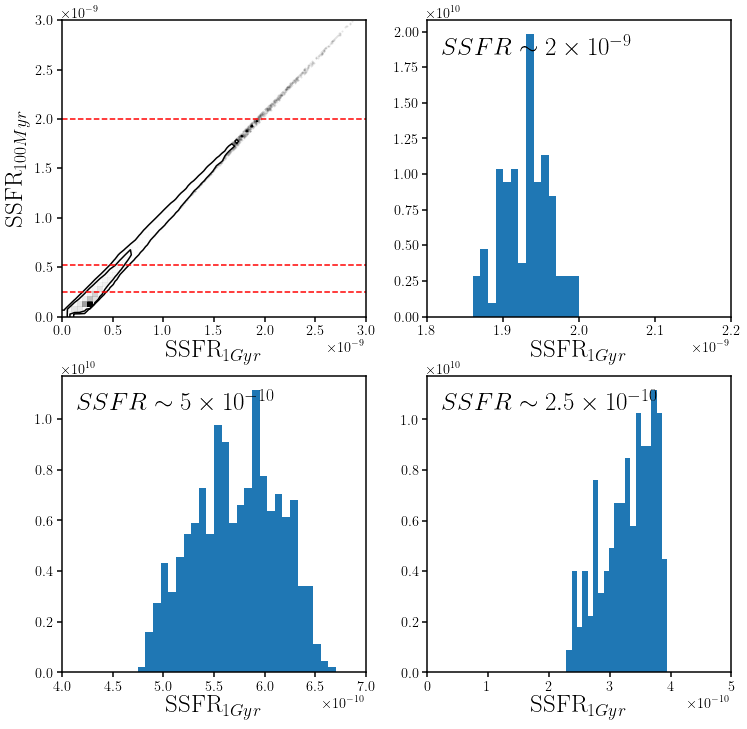

In [58]:
fig = plt.figure(figsize=(12,12))
sub = fig.add_subplot(221)

DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='k', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 3e-9]], bins=60,  
        plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
        ax=sub) 
sub.plot([0., 3e-9], [2e-9, 2e-9], c='r', ls='--')
sub.plot([0., 3e-9], [0.525e-9, 0.525e-9], c='r', ls='--')
sub.plot([0., 3e-9], [0.25e-9, 0.25e-9], c='r', ls='--')

sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)
sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_ylim(0, 3e-9)

sub = fig.add_subplot(222)
sub.hist(ssfr_1gyr[(ssfr_100myr > 1.95e-9) & (ssfr_100myr < 2.05e-9)], range=(1.8e-9, 2.2e-9), bins=40, density=True)
sub.text(0.05, 0.95, r'$SSFR \sim 2\times10^{-9}$', 
         transform=sub.transAxes, ha='left', va='top', fontsize=25)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(1.8e-9, 2.2e-9)

sub = fig.add_subplot(223)
sub.hist(ssfr_1gyr[(ssfr_100myr > 0.245e-9) & (ssfr_100myr < 0.255e-9)], range=(0.15e-9, 0.5e-9), bins=40, density=True)
sub.text(0.05, 0.95, r'$SSFR \sim 2.5\times10^{-10}$', 
         transform=sub.transAxes, ha='left', va='top', fontsize=25)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0., 0.5e-9)

sub = fig.add_subplot(224)
sub.hist(ssfr_1gyr[(ssfr_100myr > 0.095e-9) & (ssfr_100myr < 0.105e-9)], range=(0.15e-9, 0.5e-9, bins=40, density=True)
sub.text(0.05, 0.95, r'$SSFR \sim 1\times10^{-10}$', 
         transform=sub.transAxes, ha='left', va='top', fontsize=25)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0.4e-9, 0.7e-9)


In [59]:
def bestfit_gmm(x, max_comp=5): 
    # fit GMMs with a range of components 
    ncomps = range(1, max_comp+1)
    gmms, bics = [], []  
    for i_n, n in enumerate(ncomps): 
        gmm = GMix(n_components=n)
        gmm.fit(x)
        bics.append(gmm.bic(x)) # bayesian information criteria
        gmms.append(gmm)

    # components with the lowest BIC (preferred)
    i_best = np.array(bics).argmin()
    print(ncomps[i_best]) # number of components of the best-fit
    gbest = gmms[i_best] # best fit GMM 
    return gbest

In [60]:
kde_ssfr1gyr100myr = gkde(np.array([ssfr_1gyr, ssfr_100myr]) * 1e9)
gmm_ssfr1gyr100myr = bestfit_gmm(np.array([ssfr_1gyr, ssfr_100myr]).T * 1e9, max_comp=100)

54


In [62]:
_kde_samples = kde_ssfr1gyr100myr.resample(10000)
_kde_samples *= 1e-9
_gmm_samples, _ = gmm_ssfr1gyr100myr.sample(10000)
_gmm_samples = _gmm_samples.T
_gmm_samples *= 1e-9

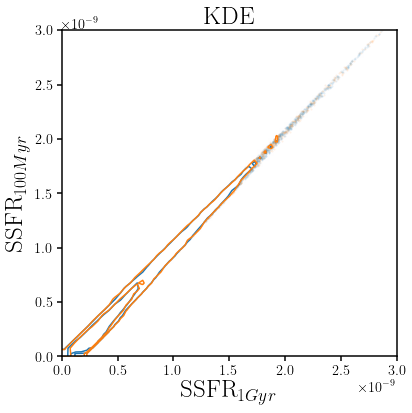

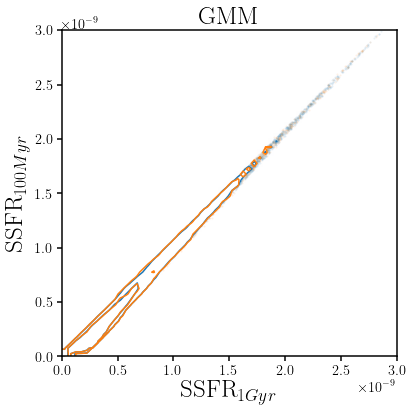

In [63]:
for _samples, name in zip([_kde_samples, _gmm_samples], ['KDE', 'GMM']):
    fig = plt.figure(figsize=(6,6))
    sub = fig.add_subplot(111)

    DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='C0', levels=[0.68, 0.95], 
            range=[[0., 3e-9], [0., 3e-9]], bins=60,
            plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
            ax=sub) 

    DFM.hist2d(_samples[0,:], _samples[1,:], color='C1', levels=[0.68, 0.95], 
            range=[[0., 3e-9], [0., 3e-9]], bins=60, label=name, 
            plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
            ax=sub) 
    sub.set_title(name, fontsize=25)
    sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
    sub.set_xlim(0, 3e-9)
    sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
    sub.set_ylim(0, 3e-9)

In [64]:
w_kde_ssfr1gyr100myr = 1./kde_ssfr1gyr100myr.pdf(np.array([ssfr_1gyr * 1e9, ssfr_100myr * 1e9]))
w_gmm_ssfr1gyr100myr = 1./np.exp(gmm_ssfr1gyr100myr.score_samples(np.array([ssfr_1gyr * 1e9, ssfr_100myr * 1e9]).T))

(0.0, 3e-09)

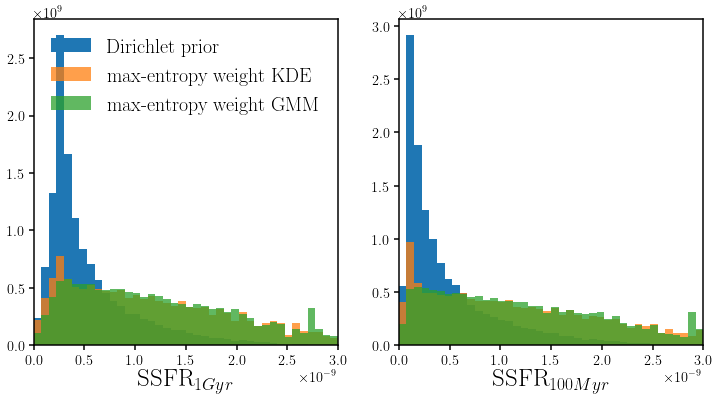

In [65]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_1gyr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight KDE')
sub.hist(ssfr_1gyr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight GMM')

sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

sub = fig.add_subplot(122)
sub.hist(ssfr_100myr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_100myr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
sub.hist(ssfr_100myr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
#sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

Lets build a MAF

In [78]:
class Mask_AR(tf.keras.models.Model):
    def __init__(self, *, output_dim, num_masked, n_bijectors=5, hidden_layer=32, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []

        permutation = tf.cast(np.concatenate((np.arange(self.output_dim / 2, self.output_dim), np.arange(0, self.output_dim / 2))),
                      tf.int32)

        # Defining the bijector
        bijectors=[] 
        num_blocks = n_bijectors
        h = hidden_layer
        for i in range(num_blocks): 
            # masked_autoregressive_default_template constructs a special network, 
            # which preserves the autoregressive property, called MADE.
            net = tfb.masked_autoregressive_default_template(hidden_layers=[h, h])
            
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net))
            
            bijectors.append(tfb.Permute(permutation)) 
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0. for i in range(self.output_dim)]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)

In [79]:
X = tf.convert_to_tensor((np.array([ssfr_1gyr, ssfr_100myr]) * 1e9).T, dtype=tf.float32)

In [80]:
maf = Mask_AR(output_dim=2, num_masked=1, n_bijectors=5, hidden_layer=200)
_ = maf(X)
print(maf.summary())

Model: "mask_ar_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 208,020
Trainable params: 208,020
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
X_dataset = tf.data.Dataset.from_tensors(X)

In [82]:
batches = X_dataset.batch(1000)

In [83]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
maf_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(maf.flow.log_prob(X))


@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

start = time()
for i in range(int(1e3+1)):
    for batch in batches:
        loss = train_step(maf, maf_optimizer, batch)
        
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   2.4624147 2.935703754425049
100   -0.8389043 30.187312841415405
200   -1.5696061 29.542447090148926
300   -1.6100855 29.85880708694458
400   -1.6527016 29.13028311729431
500   -1.6871433 30.077604055404663
600   -1.7114185 31.60801100730896
700   -1.7285949 30.574019193649292
800   -1.7407457 31.185520887374878
900   -1.747375 29.570390939712524


KeyboardInterrupt: 

In [ ]:
Z = np.random.normal(0,1,(10000,2))
_maf_samples = maf(Z).numpy().T * 1e-9

In [ ]:
for _samples, name in zip([_kde_samples, _gmm_samples, _maf_samples], ['KDE', 'GMM', 'MAF']):
    fig = plt.figure(figsize=(6,6))
    sub = fig.add_subplot(111)

    DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='C0', levels=[0.68, 0.95], 
            range=[[0., 3e-9], [0., 3e-9]], bins=60,
            plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
            ax=sub) 

    DFM.hist2d(_samples[0,:], _samples[1,:], color='C1', levels=[0.68, 0.95], 
            range=[[0., 3e-9], [0., 3e-9]], bins=60, label=name, 
            plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
            ax=sub) 
    sub.set_title(name, fontsize=25)
    sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
    sub.set_xlim(0, 3e-9)
    sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
    sub.set_ylim(0, 3e-9)

In [ ]:
w_maf_ssfr1gyr100myr = 1./np.exp(maf.flow.log_prob(X))

In [ ]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_1gyr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight KDE')
sub.hist(ssfr_1gyr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight GMM')
sub.hist(ssfr_1gyr, weights=w_maf_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight MAF')

sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

sub = fig.add_subplot(122)
sub.hist(ssfr_100myr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_100myr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
sub.hist(ssfr_100myr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
sub.hist(ssfr_100myr, weights=w_maf_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')

#sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_xlim(0, 3e-9)